In [1]:
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# other imports
import nltk
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
disaster = pd.read_csv('socialmedia-disaster-tweets-DFE.csv', encoding='ISO-8859-1')
disaster.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [3]:
disaster.shape

(10876, 13)

In [4]:
#z = {'Relevant': 'Relevant', 'Not Relevant': 'Not Relevant'}

data = [go.Bar(
    x = disaster.choose_one.unique(),
    y = disaster.choose_one.value_counts().values,
    marker = dict(colorscale = 'Jet', color = disaster.choose_one.value_counts().values),
    text = 'Text entries'
)]

layout = go.Layout(
    title = 'Target Variable Distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [5]:
all_words = disaster.text.str.split(expand=True).unstack().value_counts()

data = [go.Bar(
    x = all_words.index.values[:50],
    y = all_words.values[:50],
    marker = dict(colorscale='Jet', color = all_words.values[:100]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Top 50(Uncleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## Wordclouds

In [6]:
relevant = disaster[disaster.choose_one == 'Relevant']['text']
not_relevant = disaster[disaster.choose_one == 'Not Relevant']['text']
cant_decide = disaster[disaster.choose_one == "Can't Decide"]['text']

In [7]:
# encode pic
with open('pics/images.png', 'rb') as ImageFile:
    rel_64 = base64.b64encode(ImageFile.read())

In [8]:
# decode pic
import codecs
f1 = open('pics/relevant.png', 'wb')
f1.write(codecs.decode(rel_64, 'base64'))
f1.close()
img1 = imread('pics/relevant.png')
hcmask = img1

C:\Users\PARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

`imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.



(-0.5, 1199.5, 629.5, -0.5)

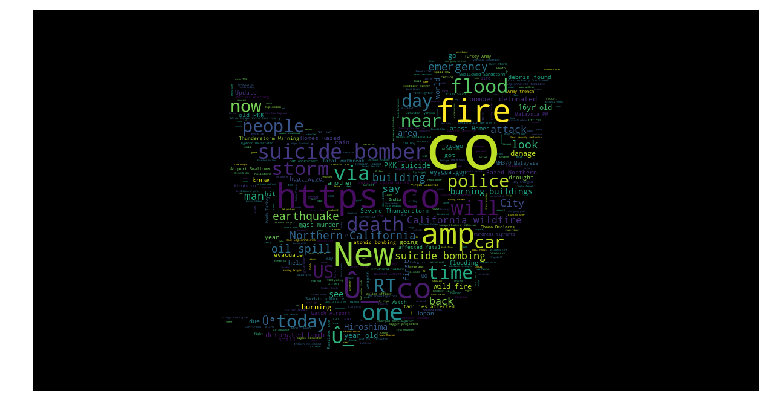

In [9]:
# Wordcloud for relevant

plt.figure(figsize=(13,13))
wc = WordCloud(background_color='black', stopwords=STOPWORDS, max_words=500, mask = hcmask)
wc.generate(" ".join(relevant))
plt.imshow(wc)
plt.axis('off')

(-0.5, 1199.5, 629.5, -0.5)

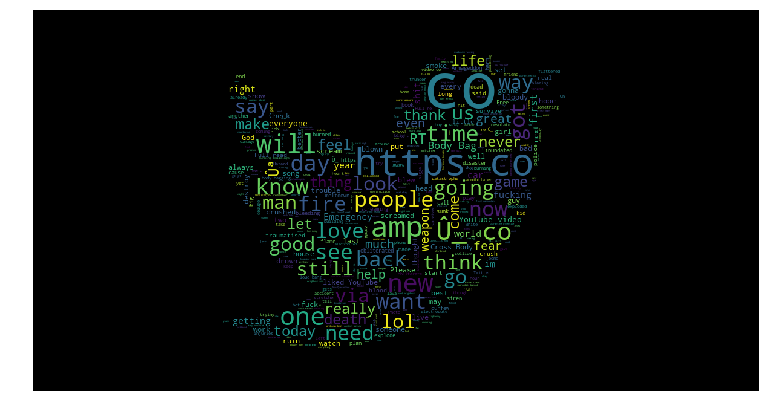

In [10]:
# Wordcloud for not-relevant

plt.figure(figsize=(13,13))
wc = WordCloud(background_color='black', stopwords=STOPWORDS, max_words=500, mask = hcmask)
wc.generate(" ".join(not_relevant))
plt.imshow(wc)
plt.axis('off')

(-0.5, 1199.5, 629.5, -0.5)

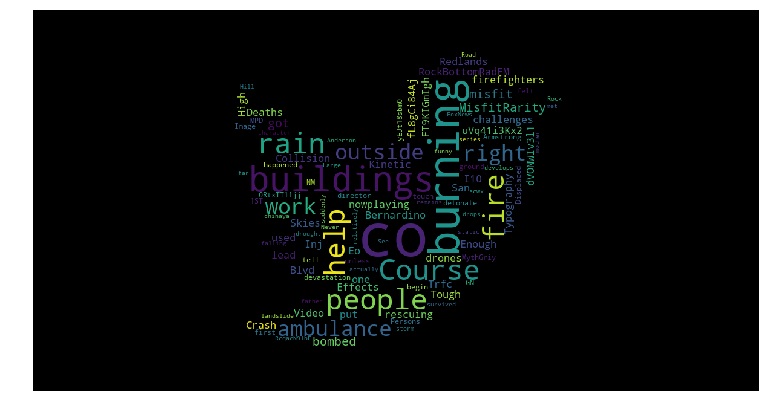

In [11]:
# Wordcloud for can't-decide

plt.figure(figsize=(13,13))
wc = WordCloud(background_color='black', stopwords=STOPWORDS, max_words=500, mask = hcmask)
wc.generate(" ".join(cant_decide))
plt.imshow(wc)
plt.axis('off')

## Natural Language Processing

- Tokenization
- Stopwords
- Stemming
- Vectorization

### Tokenization

In [12]:
dataset = disaster.copy()

# basic splitting (not a good approach)
first_text = dataset.text[10]
print(first_text)
print("="*90)
print(first_text.split(" "))

#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
['#flood', '#disaster', 'Heavy', 'rain', 'causes', 'flash', 'flooding', 'of', 'streets', 'in', 'Manitou,', 'Colorado', 'Springs', 'areas']


In [13]:
# Using NLTK

first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['#', 'flood', '#', 'disaster', 'Heavy', 'rain', 'causes', 'flash', 'flooding', 'of', 'streets', 'in', 'Manitou', ',', 'Colorado', 'Springs', 'areas']


### STOPWORDS

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

In [15]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)

['#', 'flood', '#', 'disaster', 'Heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'Manitou', ',', 'Colorado', 'Springs', 'areas']


### Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()

In [17]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [18]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


In [19]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The stemmed form of leaves is: {}".format(lemm.lemmatize("leaves")))

The stemmed form of leaves is: leaf


### Vectorization

In [20]:
sentence = ['I love to eat Burgers', 'I love to eat Fries']
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

In [21]:
print("The features are :\n {}".format(vectorizer.get_feature_names()))
print("The vectorized array looks like :\n {}".format(sentence_transform.toarray()))

The features are :
 ['burgers', 'eat', 'fries', 'love', 'to']
The vectorized array looks like :
 [[1 1 0 1 1]
 [0 1 1 1 1]]


## Latent Dirichlet Allocation

In [22]:
# Helper function to print top-words

def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [23]:
# Extending the CountVectorizer with a lemmatizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [24]:
# Storing entire training text in a list
text = list(dataset.text.values)

# Calling LemmaCountVectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [25]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

data = [go.Bar(
    x = x[0:50],
    y = y[0:50],
    marker = dict(colorscale='Jet', color = y[:50]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Top 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [26]:
data = [go.Bar(
    x = x[-50:],
    y = y[-50:],
    marker = dict(colorscale='Jet', color = y[-50:]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Bottom 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## Latent Dirichlet Allocation

In [27]:
lda = LatentDirichletAllocation(n_components=3, max_iter=15, learning_method='online', learning_offset= 50., random_state=42)

In [28]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=15, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [29]:
n_top_words = 40
print("\n Topics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


 Topics in LDA model: 

Topic #0http amp like just don year time world look got make love going video let war hiroshima need day dead youtube know injury way weapon mass death right say ll car help come today lol feel god man accident police

Topic #1http û_ new news disaster suicide storm california crash family fire home woman wildfire police 2015 gt bomber mh370 watch flood army kill video photo collapse pm state attack northern reddit read obama rt typhoon post latest legionnaire killed 15

Topic #2http people emergency life just nuclear service like train did plan body forest burning thing building really live thunderstorm wave hot stop warning severe oil game as red work im getting sound û_ good heat face evacuation ûò spill loud


In [30]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

In [31]:
first_topic.shape

(7498,)

In [32]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
#fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

### Wordcloud of first topic

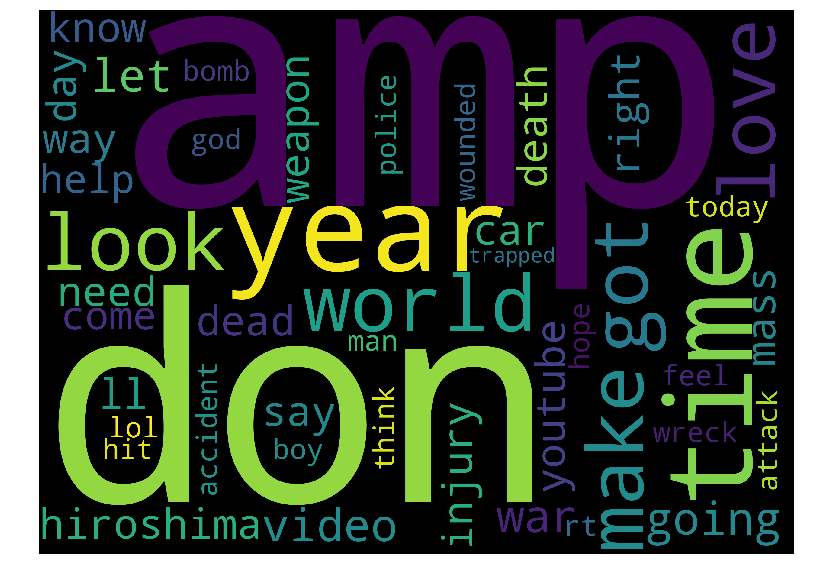

In [33]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

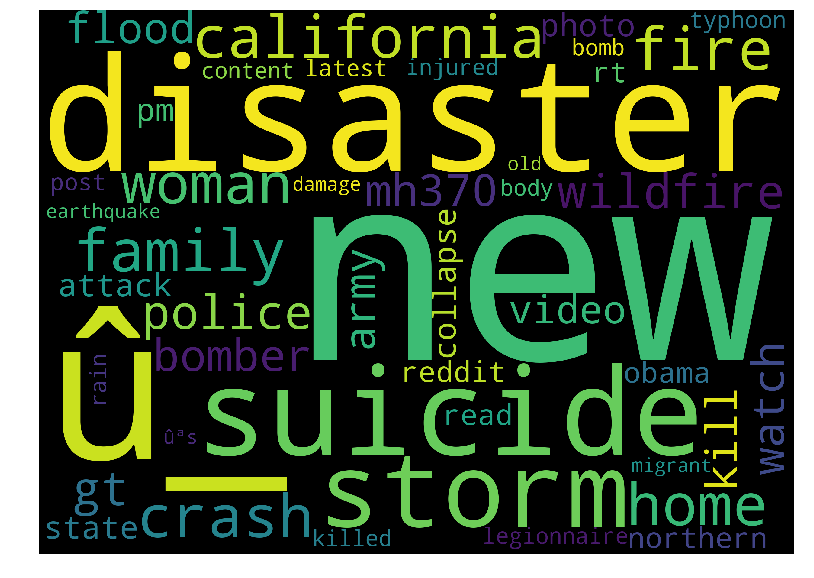

In [34]:
# Generating the wordcloud with the values under the category dataframe
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

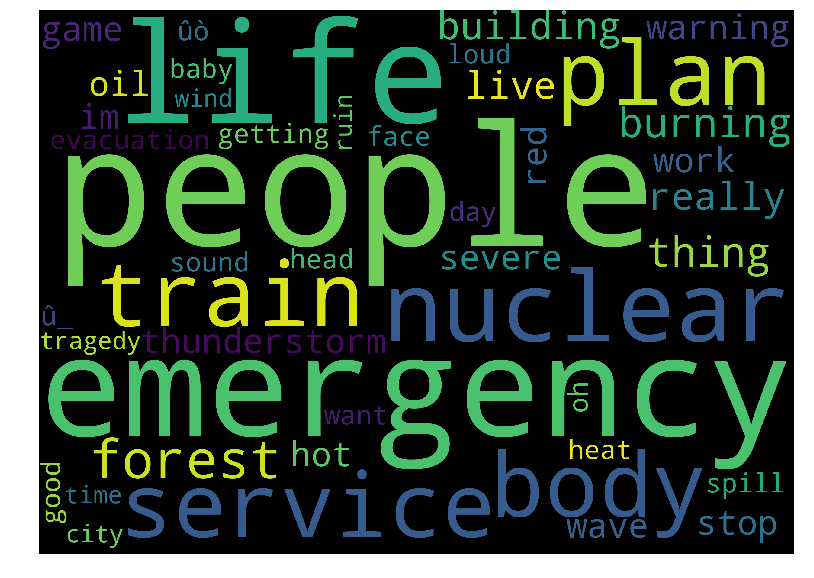

In [35]:
# Generating the wordcloud with the values under the category dataframe
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()